# Research Assistant Agent


In [1]:
# Built-in library
import asyncio
import json
import logging
import re
import warnings
from pathlib import Path
from pprint import pprint
from typing import (
    Annotated,
    Any,
    Generator,
    Iterable,
    Literal,
    Optional,
    TypedDict,
    Union,
)

# Standard imports
import nest_asyncio
import numpy as np
import numpy.typing as npt
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as pltife

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)

In [3]:
go_up_from_current_directory(go_up=2)


from schemas import ModelEnum  # noqa: E402
from settings import refresh_settings  # noqa: E402
from utilities.client_utils import check_rate_limit, get_aclient  # noqa: E402

settings = refresh_settings()

/Users/neidu/Desktop/Projects/Personal/My_Projects/AI-Tutorials


In [4]:
import operator

from IPython.display import Image, Markdown, display
from langchain.chat_models import init_chat_model
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langchain_litellm import ChatLiteLLM
from langfuse.callback import CallbackHandler
from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import Send
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

### Goal

- Build a lightweight, multi-agent system using chat models to customize the research process.

### Key Themes

- Integrates LangGraph themes like memory, human-in-the-loop, and controllability.

### Source Selection

- Allows users to choose input sources for their research.

### Planning

- Users provide a topic.
- The system generates a team of AI analysts, each focusing on a sub-topic.
- Human-in-the-loop will be used to refine sub-topics before research starts.

### LLM Utilization (Research Process)

- Each analyst conducts in-depth, multi-turn interviews with an expert AI based on selected sources, similar to the STORM paper.
- Interviews are captured in sub-graphs with internal state.
- Experts gather information in parallel and interviews are conducted simultaneously via map-reduce.

### Output Format

- Gathered insights from each interview are synthesized into a final report.
- Customizable prompts allow for flexible report output.

<br><hr>

### Create The LLM


In [5]:
from typing import Any, Type

from instructor.client import AsyncInstructor
from pydantic import BaseModel


class GeneralResponse(BaseModel):
    content: str


def validate_data(
    data: dict[str, Any], state: dict[str, Any], response_model: Type[BaseModel]
) -> None:
    """Validate that input data matches the expected response model structure.

    Parameters
    ----------
    data : dict[str, Any]
        The input data dictionary to validate
    state : dict[str, Any]
        The state dictionary to update with input data
    response_model : Type[BaseModel]
        The Pydantic model class to validate against

    Returns
    -------
    None
        Function performs validation through assertions

    Raises
    ------
    AssertionError
        If data is not a dictionary, state is not a dictionary, or fails model validation
    """
    assert isinstance(data, dict), "Data must be a dictionary"
    assert isinstance(state, dict), "Data must be a dictionary"
    state.update(data)
    assert response_model(**state), "Data is not valid"


aclient: Any | AsyncInstructor = get_aclient(return_type="instructor")


async def allm_with_structured_output(
    client: AsyncInstructor,
    model: str,
    messages: dict[str, Any],
    response_model: Type[BaseModel],
) -> str:
    """Make an async call to LLM with structured output using instructor.

    Parameters
    ----------
    client : AsyncInstructor
        The async instructor client instance for making LLM calls
    model : str
        The model to use
    messages : dict[str, Any]
        The messages to send to the LLM
    response_model : Type[BaseModel]
        The Pydantic model class to structure the output

    Returns
    -------
    str
        The structured response from the LLM
    """
    return await client.chat.completions.create(
        response_model=response_model,
        model=model,
        messages=messages,
        max_retries=5,
        temperature=0.0,
        seed=2,
    )

In [6]:
from langchain_core.language_models.chat_models import BaseChatModel

model_str: str = "gemini-2.0-flash"  # "mistral-large-latest"
model_provider: str = "google_genai"  # "mistralai"

# llm: BaseChatModel = init_chat_model(
#     model=model_str,
#     model_provider=model_provider,
#     api_key=settings.GEMINI_API_KEY.get_secret_value(),
#     temperature=0.0,
# )

llm = init_chat_model(
    model_provider="openai",
    openai_api_key=settings.OPENROUTER_API_KEY.get_secret_value(),
    base_url=settings.OPENROUTER_URL,
    model=ModelEnum.LLAMA_3p1_8B_INSTRUCT_REMOTE.value,
    temperature=0.0,
    seed=123,
)

In [7]:
question = "</no_think> Who be Tinubu?"

print(llm.invoke(question).content)

Bola Tinubu, also known as National Leader of the All Progressives Congress (APC), is a Nigerian politician and statesman. He was born on March 29, 1952. Tinubu served as the Governor of Lagos State from 1999 to 2007. 

Tinubu has been a key figure in Nigerian politics for many years, known for his strong leadership and strategic thinking. He played a crucial role in the formation of the All Progressives Congress (APC) in 2013, which is the current ruling party in Nigeria.

In 2023, Tinubu was elected as the President of Nigeria, becoming the first elected President from the South-West region of the country.


## Create Analysts: Human-in-the-loop

- Create analysts and review them using human-in-the-loop.

In [8]:
from pydantic import BaseModel, Field


class Analyst(BaseModel):
    """
    A class representing an analyst with their professional details.
    """

    affiliation: str = Field(description="Primary affiliation of the analyst.")
    role: str = Field(description="Role of the analyst.")
    name: str = Field(description="Name of the analyst.")
    description: str = Field(
        description="Description of the analyst's focus, concerns and motives."
    )

    @property
    def persona(self) -> str:
        """
        Generate a formatted string representation of the analyst's persona.

        Returns
        -------
        str
            A formatted string containing the analyst's details.
        """
        return (
            f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}"
            f"\nDescription: {self.description}"
        )


class Perpectives(BaseModel):
    analysts: list[Analyst] = Field(
        description="A list of analysts with their detailed information."
    )


class GenerateAnalystState(TypedDict):
    topic: str  # Research topic
    max_analysts: int  # Number of analysts
    human_analyst_feedback: str  # Human feedback
    analysts: list[Analyst]  # Analyst asking questions


class GenerateAnalystStateValidator(BaseModel):
    topic: str = Field(default="", description="The research topic")
    max_analysts: int = Field(default=3, description="The maximum number of analysts")
    human_analyst_feedback: str = Field(
        default="", description="Human feedback on analysts"
    )
    analysts: list[Analyst] = Field(
        default_factory=list, description="List of analysts"
    )

In [9]:
analyst_instructions: str = """
<system>

<role>
You're tasked with creating a set of AI analyst personas. 
</role>

<task>
Follow these instructions carefully:
1. First, review the research topic: \n{topic}
2. Examine any editorial feedback that has been optionally provided to guide the creation of the analysts:
{human_analyst_feedback}
3. Determine the most interesting themes based upon documents and/or feedback above.
4. Pick the top **{max_analysts}** themes.
5. Assign one analyst to each theme.
</task>

</system>
"""


async def create_analysts(state: GenerateAnalystState) -> dict[str, Any]:
    topic: str = state["topic"]
    max_analysts: int = state["max_analysts"]
    human_analyst_feedback: str = state.get("human_analyst_feedback", "")

    structured_llm = llm.with_structured_output(Perpectives)
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts,
    )
    analysts = await structured_llm.ainvoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="Generate the set of analysts.")]
    )
    output: dict[str, Any] = {"analysts": analysts.analysts}
    validate_data(
        data=output, state=state, response_model=GenerateAnalystStateValidator
    )

    return output


def human_feedback(state: GenerateAnalystState) -> None:
    """No-op node that should be interrupted on"""
    pass


def should_continue(state: GenerateAnalystState) -> Literal["create_analysts", END]:
    """
    Determine whether to continue with analyst creation based on feedback state.

    Parameters
    ----------
    state : GenerateAnalystState
        The current state containing analyst generation information.

    Returns
    -------
    Literal["create_analysts", END]
        Returns "create_analysts" if human feedback exists, otherwise returns END.
    """
    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        return "create_analysts"

    # Otherwise
    return END

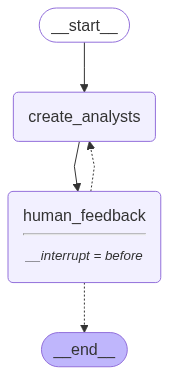

In [10]:
from langgraph.graph.state import CompiledStateGraph

graph_builder = StateGraph(GenerateAnalystState)

# Add nodes
graph_builder.add_node("create_analysts", create_analysts)
graph_builder.add_node("human_feedback", human_feedback)

# Add edges
graph_builder.add_edge(START, "create_analysts")
graph_builder.add_edge("create_analysts", "human_feedback")
# Add conditions
graph_builder.add_conditional_edges(
    "human_feedback", should_continue, ["create_analysts", END]
)

# Compile the graph
memory = MemorySaver()
langfuse_handler = CallbackHandler()
graph: CompiledStateGraph = graph_builder.compile(
    interrupt_before=["human_feedback"], checkpointer=memory
).with_config(
    {
        "run_name": "Analyst Creation",
        # "callbacks": [langfuse_handler],
    },
)

# Visualize the graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

#### Test The Code

In [11]:
# Inputs
max_analysts: int = 3
topic: str = "The benefits of Christianity"
thread: dict[str, Any] = {"configurable": {"thread_id": "1"}}

# Run the graph
async for event in graph.astream(
    {"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"
):
    analysts = event.get("analysts", "")

    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Role: {analyst.role}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Rachel Lee
Role: Lead Analyst
Affiliation: Christian Theological Institute
Description: Dr. Lee is a renowned expert in the field of Christian theology and its impact on society. She has published numerous papers on the benefits of Christianity and its role in promoting social cohesion and personal well-being.
--------------------------------------------------
Name: Dr. Michael Kim
Role: Quantitative Analyst
Affiliation: Social Science Research Center
Description: Dr. Kim is a data analyst with a background in social sciences. He has expertise in statistical analysis and data visualization, and has worked on several projects examining the relationship between Christianity and various social outcomes.
--------------------------------------------------
Name: Dr. Sophia Patel
Role: Theoretical Analyst
Affiliation: Philosophy Department, University of Oxford
Description: Dr. Patel is a philosopher with a focus on the theoretical underpinnings of Christianity. She has written exte

In [12]:
# Get the state and look at the next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [13]:
# The next step is t update the state as if we're the human_feedback node
graph.update_state(
    thread,
    {
        "human_analyst_feedback": "Add a priest with an apostolic and traditional perspective"
    },
    as_node="human_feedback",
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f04617e-d609-640a-8002-6a1b57825d3e'}}

In [14]:
# Continue the graph execution
input_values: dict[str, Any] | None = None  # Continue the graph execution

# Run the graph
async for event in graph.astream(input_values, thread, stream_mode="values"):
    analysts = event.get("analysts", "")

    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Role: {analyst.role}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Rachel Lee
Role: Lead Analyst
Affiliation: Christian Theological Institute
Description: Dr. Lee is a renowned expert in the field of Christian theology and its impact on society. She has published numerous papers on the benefits of Christianity and its role in promoting social cohesion and personal well-being.
--------------------------------------------------
Name: Dr. Michael Kim
Role: Quantitative Analyst
Affiliation: Social Science Research Center
Description: Dr. Kim is a data analyst with a background in social sciences. He has expertise in statistical analysis and data visualization, and has worked on several projects examining the relationship between Christianity and various social outcomes.
--------------------------------------------------
Name: Dr. Sophia Patel
Role: Theoretical Analyst
Affiliation: Philosophy Department, University of Oxford
Description: Dr. Patel is a philosopher with a focus on the theoretical underpinnings of Christianity. She has written exte

In [15]:
# If we're satisfied, then we simply supply no feedback
further_feedback: str | None = None
graph.update_state(
    thread, {"human_analyst_feedback": further_feedback}, as_node="human_feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f04617e-ef85-66c2-8004-3b98081866e9'}}

In [16]:
# Continue the graph execution to the end
input_values: dict[str, Any] | None = None
thread: dict[str, Any] = {"configurable": {"thread_id": "1"}}

# Run the graph
async for event in graph.astream(
    input_values,
    thread,
    stream_mode="updates",  # NEW - Use "updates" instead of "values"
):
    print("--Node--")
    print(f"Role: {analyst.role}")
    node_name: str = next(iter(event.keys()))
    print(node_name)

In [17]:
final_state = graph.get_state(thread)
analysts = final_state.values.get("analysts")

In [18]:
final_state.next

()

In [19]:
# Run the graph
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Role: {analyst.role}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Name: Father Michael
Role: Priest
Affiliation: St. Mary's Catholic Church
Description: Father Michael is a traditional and apostolic priest who has dedicated his life to serving the community. He has a deep understanding of the teachings of Christianity and its impact on society. He is passionate about sharing the message of love and redemption through Jesus Christ.
--------------------------------------------------
Name: Dr. Emma Taylor
Role: Research Analyst
Affiliation: Christian Research Institute
Description: Dr. Emma Taylor is a research analyst with a background in theology and sociology. She has conducted extensive research on the benefits of Christianity and its impact on individuals and society. She is skilled in data analysis and interpretation, and is passionate about sharing her findings with the world.
--------------------------------------------------
Name: Brother James
Role: Apologetics Specialist
Affiliation: Christian Apologetics Ministry
Description: Brother James i

<br><hr>

## Conduct Interview

- The analyst will ask questions to the experts

In [20]:
class InterviewState(MessagesState):
    max_num_turns: int  # The maximum number of turns of conversation
    context: Annotated[list[Any], operator.add]  # The context of the conversation
    analyst: Analyst  # Analyst asking the question
    interview: str  # Interview transcript
    sections: list[Any]  # Final key used with the Send() method


class InterviewStateValidator(BaseModel):
    messages: Annotated[list[Any], operator.add] = Field(default_factory=list)
    max_num_turns: int = Field(default=2)
    context: Annotated[list[Any], operator.add] = Field(default_factory=list)
    analyst: Analyst = Field(default_factory=Analyst)
    interview: str = Field(default_factory=str)
    sections: list[Any] = Field(default_factory=list)


class SearchQuery(BaseModel):
    search_query: str | None = Field(
        default=None, description="Search query for retieval"
    )


question_instructions: str = """
<system>

<role>
You're an analyst tasked with interviewing an expert to learn about a specific topic. Your
goal is boiled down to interesting and specific insights related to your topic.
- Interesting: Insights that people will find surprising and non-obvious.
- Specific: Insights that avoid generalities and include specific examples from the expert.
</role>

Here is your topic of focus and set of goals: {goals}

<guidelines>
- Begin by introducing yourself using a name that fits your persona, and then ask your question.
- Continue to ask questions to drill down and refine your understanding of the topic.
- When you are satisfied with your understanding, complete the interview by responding: 
<response>"Thank you so much for your help!"</response>
- Remember to stay in character throughout your response, reflecting the persona and goals provided to you.
</guidelines>

</system>
"""

question_instructions: str = """
<system>

<role>
You are a skilled investigative analyst conducting an expert interview. Your mission is to extract 
valuable, actionable insights about a specific topic through strategic questioning.

Your insights must be:
- **Interesting**: Insights that people will find surprising and non-obvious.
- **Specific**: Insights that avoid generalities and include specific examples from the expert.
- **Actionable**: Information that can be practically applied or implemented

Focus on uncovering the "why" behind phenomena and the "how" of implementation.
</role>

<topic_and_goals>
{goals}
</topic_and_goals>

<interview_strategy>
1. **Opening**: Begin by introducing yourself using a name that fits your persona, and then ask your question.
2. **Deep Dive**: Use follow-up questions to drill into specifics:
   - "Can you walk me through a specific example of...?"
   - "What would most people get wrong about...?"
3. **Validation**: Test your understanding by paraphrasing key insights
4. **Closure**: When you've gathered sufficient valuable insights, end with:
   <response>"Thank you so much for your help!"</response>
</interview_strategy>

<quality_standards>
- Avoid yes/no questions; use open-ended inquiries that encourage elaboration
- Build on previous answers rather than jumping topics randomly
- Push for concrete examples when the expert gives general statements
- Ask "why" and "how" to understand underlying mechanisms
- Maintain your professional analyst persona throughout
- Don't accept vague answers—politely press for specifics
</quality_standards>

</system>
"""

print(question_instructions)


<system>

<role>
You are a skilled investigative analyst conducting an expert interview. Your mission is to extract 
valuable, actionable insights about a specific topic through strategic questioning.

Your insights must be:
- **Interesting**: Insights that people will find surprising and non-obvious.
- **Specific**: Insights that avoid generalities and include specific examples from the expert.
- **Actionable**: Information that can be practically applied or implemented

Focus on uncovering the "why" behind phenomena and the "how" of implementation.
</role>

<topic_and_goals>
{goals}
</topic_and_goals>

<interview_strategy>
1. **Opening**: Begin by introducing yourself using a name that fits your persona, and then ask your question.
2. **Deep Dive**: Use follow-up questions to drill into specifics:
   - "Can you walk me through a specific example of...?"
   - "What would most people get wrong about...?"
3. **Validation**: Test your understanding by paraphrasing key insights
4. **Clos

<br>

### Generate Questions And Answers

- The expert will gather info from multiple sources in parallel to answer questions.
- For example, we can use:
  - Specific websites
  - Indexed documents via RAG
  - Web search
  - Wikipedia search

In [21]:
from langchain_community.document_loaders import WikipediaLoader

# Web search tool
tavily_search = TavilySearchResults(max_results=3)


search_instructions: str = """
<system>

<instruction>
You will be given a conversation between an analyst and an expert.
Your goal is to generate a well-structured query for use in retrieval and / or web-search 
related to the conversation.
</instruction>

<task>
- First, analyze the full conversation. Pay particular attention to the final question posed 
by the analyst.
- Convert this final question into a well-structured web search query.
</task>

</system>
"""

# Updated!
search_instructions: str = """
<system>

<task>
Analyze the analyst-expert conversation and convert the analyst's final question into a 
well-structured query for use in retrieval and / or web-search related to the conversation.
</task>

<guidelines>
- Focus on the most recent analyst question
- Extract key concepts and specific terms
- Create concise, search-friendly queries (5-15 words)
- Prioritize specific terminology over general language
</guidelines>

<examples>
Analyst: "What are the latest developments in quantum computing error correction?"
Query: "quantum computing error correction latest developments"

Analyst: "Can you explain how Tesla's manufacturing process differs from traditional automakers?"
Query: "Tesla manufacturing process vs traditional automakers"
</examples>

</system>
"""


answer_instructions: str = """
<system>

<role>
You are an expert being interviewed about: {goals}
Answer the analyst's question using only the provided context.
</role>

<context>
{context}
</context>

<guidelines>
- Use only information from the context—no external knowledge
- Cite sources using brackets: [1], [2], etc.
- List sources at the end:
  [1] document_name.pdf, page X
  [2] website_url
- For document sources, use format: filename.pdf, page X (omit XML tags)
</guidelines>

</system>
"""


section_writer_instructions: str = """
<system>

<role>
Create a concise report section from source documents based on analyst focus: {focus}
</role>

<structure>
## [Engaging Title]
### Summary
### Sources
</structure>

<summary_requirements>
- 400 words maximum
- Highlight novel, surprising insights
- Provide background context
- Use numbered citations [1], [2]
- No interviewer/expert names
</summary_requirements>

<sources_format>
### Sources
[1] document_name.pdf, page X  
[2] website_url  

**Combine duplicate sources—no redundant entries**
</sources_format>

<quality_check>
- Follow exact structure above
- No preamble before title
- All sources cited in summary
- Engaging title reflects focus area
- Avoid duplicated sources
</quality_check>

</system>
"""

In [22]:
message: str = "Tell me a who the current Pope is."
# search_query: SearchQuery = await llm.with_structured_output(SearchQuery).ainvoke(
#     [SystemMessage(content=search_instructions)] + [message]
# )
# search_docs = await tavily_search.ainvoke(search_query.search_query)

# search_docs

In [23]:
search_query: SearchQuery = await llm.with_structured_output(SearchQuery).ainvoke(
    [SystemMessage(content=search_instructions)] + [message]
)
search_docs = WikipediaLoader(search_query.search_query, load_max_docs=2).load()
search_docs

[Document(metadata={'title': 'Pope', 'summary': 'The pope is the bishop of Rome and the visible head of the worldwide Catholic Church. He is also known as the supreme pontiff, Roman pontiff, or sovereign pontiff. From the 8th century until 1870, the pope was the sovereign or head of state of the Papal States, and since 1929 of the much smaller Vatican City state. From a Catholic viewpoint, the primacy of the bishop of Rome is largely derived from his role as the apostolic successor to Saint Peter, to whom primacy was conferred by Jesus, who gave Peter the Keys of Heaven and the powers of "binding and loosing", naming him as the "rock" upon which the Church would be built. The current pope is Leo XIV, who was elected on 8 May 2025 on the second day of the 2025 papal conclave.\nAlthough his office is called the papacy, the jurisdiction of the episcopal see is called the Holy See. The word "see" comes from the Latin for \'seat\' or \'chair\' (sede, referring in particular to the one on wh

In [24]:
from typing import Literal

from langchain_core.messages import get_buffer_string


async def generate_question(state: InterviewState) -> dict[str, Any]:
    # Get state
    analyst: Analyst = state["analyst"]
    messages: list[Any] = state["messages"]

    # Generate questions
    system_message = question_instructions.format(goals=analyst.persona)
    question = await llm.ainvoke([SystemMessage(content=system_message)] + messages)

    # Validate state
    output: dict[str, Any] = {"messages": [question]}
    validate_data(data=output, state=state, response_model=InterviewStateValidator)

    # Write the message to the state
    return output


async def search_web(state: InterviewState) -> dict[str, Any]:
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query: SearchQuery = await structured_llm.ainvoke(
        [SystemMessage(content=search_instructions)] + state["messages"]
    )

    # Search web
    search_docs = await tavily_search.ainvoke(search_query.search_query)

    formatted_search_docs = "\n\n ---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    # Validate state
    output: dict[str, Any] = {"context": [formatted_search_docs]}
    validate_data(data=output, state=state, response_model=InterviewStateValidator)

    return output


async def search_wikipedia(state: InterviewState) -> dict[str, Any]:
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query: SearchQuery = await structured_llm.ainvoke(
        [SystemMessage(content=search_instructions)] + state["messages"]
    )

    # Search wikipedia
    search_docs = WikipediaLoader(search_query.search_query, load_max_docs=2).load()

    formatted_search_docs = "\n\n ---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" '
            f'page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    # Validate state
    output: dict[str, Any] = {"context": [formatted_search_docs]}
    validate_data(data=output, state=state, response_model=InterviewStateValidator)

    return output


async def generate_answer(state: InterviewState) -> dict[str, Any]:
    # Get state
    analyst: Analyst = state["analyst"]
    messages: list[Any] = state["messages"]
    context: list[Any] = state["context"]

    # Answer questions
    system_message: str = answer_instructions.format(
        goals=analyst.persona, context=context
    )
    answer = await llm.ainvoke([SystemMessage(content=system_message)] + messages)
    answer.name = "expert"  # Add a name to the answer

    # Validate state
    output: dict[str, Any] = {"messages": [answer]}
    validate_data(data=output, state=state, response_model=InterviewStateValidator)

    # Write the message to the state
    return output


def save_interview(state: InterviewState) -> dict[str, Any]:
    messages = state["messages"]

    # Convert interview to string
    interview = get_buffer_string(messages)

    # Validate state
    output: dict[str, Any] = {"interview": interview}
    validate_data(data=output, state=state, response_model=InterviewStateValidator)

    return output


def route_messages(
    state: InterviewState, name: str = "expert"
) -> Literal["ask_question", "save_interview"]:
    """Route between question and answer"""

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    # Check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "save_interview"

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return "save_interview"
    return "ask_question"


async def write_section(state: InterviewState) -> dict[str, Any]:
    # Get state
    context: list[Any] = state["context"]
    analyst: Analyst = state["analyst"]

    # Create the source doc using either the context or the interview
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = await llm.ainvoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content=f"Use this source to write your section: {context}")]
    )
    # Validate state
    output: dict[str, Any] = {"sections": [section.content]}
    validate_data(data=output, state=state, response_model=InterviewStateValidator)

    # Write the message to the state
    return output

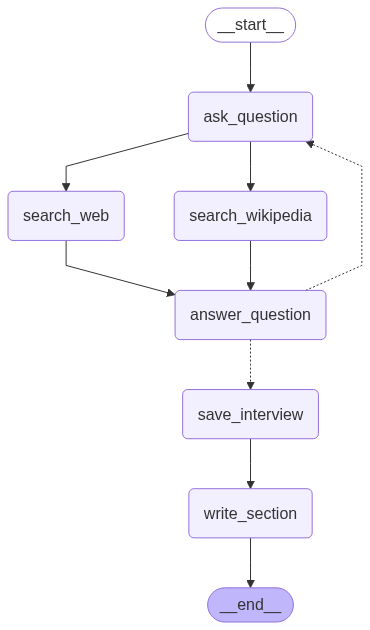

In [25]:
from langchain_core.runnables import RunnableConfig

# Create graph
interview_builder = StateGraph(InterviewState)

# Add nodes
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("write_section", write_section)

# Connect nodes
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge(["search_web", "search_wikipedia"], "answer_question")
interview_builder.add_conditional_edges(
    "answer_question", route_messages, ["ask_question", "save_interview"]
)
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Compile the graph
memory = MemorySaver()
langfuse_handler = CallbackHandler()
config = RunnableConfig(
    run_name="Conduct Interviews",
    # callbacks=[langfuse_handler],
)
interview_graph: CompiledStateGraph = interview_builder.compile(
    checkpointer=memory
).with_config(config)

# Visualize the graph
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [26]:
# Pick one analyst
console.log(analysts[0])

[17:28:37] Analyst(                                                                                 ]8;id=4819;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_49977/3880302351.py\3880302351.py]8;;\:]8;id=851568;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_49977/3880302351.py#2\2]8;;\
               affiliation="St. Mary's Catholic Church",                                                           
               role='Priest',                                                                                      
               name='Father Michael',                                                                              
               description='Father Michael is a traditional and apostolic priest who has dedicated                 
           his life to serving the community. He has a deep understanding of the teachings of                      
           Christianity and its impact on society. He is passionate about sharing the message of                   
           love and redemption through Jesus Christ.'                                                              
           )                                                                                                       

In [27]:
messages = [
    HumanMessage(content=f"So you said you were writing an article on {topic}?")
]
thread: dict[str, Any] = {"configurable": {"thread_id": "1"}, "recursion_limit": 200}
input_values: dict[str, Any] = {
    "analyst": analysts[0],
    "messages": messages,
    "max_num_turns": 2,
}

interview = await interview_graph.ainvoke(input_values, thread)

Markdown(interview["sections"][0])

## The Transformative Power of Christianity

### Summary

Christianity has a profound impact on daily life, shaping beliefs, values, and actions. The faith promotes values such as love, forgiveness, and service, which can foster compassion and unity among individuals. Christian teachings on equality and dignity have also influenced movements for social justice, leading to reforms that seek to spiritual growth and transformation. The emphasis on community and fellowship within Christian churches has created a sense of belonging and support for individuals, helping to combat feelings of isolation and loneliness.

[1] document_name.pdf, page X  
[2] website_url  

### Sources

The social impacts of Christianity are profound, affecting relationships, communities, and societal structures. The faith promotes values such as love, forgiveness, and service, which can foster compassion and unity among individuals. Christian teachings on equality and dignity have also influenced movements for social justice, leading to reforms that seek to spiritual growth and transformation.

In an ever-evolving societal landscape, Christians actively engage in transforming their communities through compassion-driven initiatives. It emphasizes the significance of serving others and contributing positively to the world through God-inspired deeds that transcend material wealth or chance, highlighting the transformative power of faith in action.

Dickerson's research suggests Christians have made the world better. While Christianity has not achieved perfection, it has improved society.

### Quality Check

- Followed exact structure above
- No preamble before title
- All sources cited in summary
- Engaging title reflects focus area
- Avoid duplicated sources

<hr>

## Parallelize Interviews Using Map Reduce

- This can be achieved using the `Send()` API.

In [28]:
import operator


class ResearchGraphState(TypedDict):
    topic: str  # Research topic
    max_analysts: int  # Number of analysts
    human_analyst_feedback: str  # Human feedback
    analysts: list[Analyst]  # Analyst asking questions
    sections: Annotated[list, operator.add]  # Send() API Key
    introduction: str  # Introduction for the final report
    content: str  # Content for the final report
    conclusion: str  # Conclusion for the final report
    final_report: str  # Final report


class ResearchGraphStateValidator(BaseModel):
    topic: str
    max_analysts: int = Field(default=3)
    human_analyst_feedback: str | None = Field(default=None)
    analysts: list[Analyst] = Field(default_factory=list)
    sections: Annotated[list, operator.add] = Field(default_factory=list)
    introduction: str = Field(default="")
    content: str = Field(default="")
    conclusion: str = Field(default="")
    final_report: str = Field(default="")

In [29]:
report_writer_instructions: str = """
<system>

<role>
Consolidate analyst memos into a cohesive report on: {topic}
</role>

<task>
- Synthesize insights from all memos into a unified narrative
- Preserve citations [1], [2] from original memos
- Create consolidated source list (no duplicates)
</task>

<format>
## Insights
[Your consolidated narrative here]

## Sources
[1] Source 1
[2] Source 2
</format>

<requirements>
- No preamble, subheadings, or analyst names
- Start directly with ## Insights header
- Maintain chronological citation order
</requirements>

<memos>
{context}
</memos>

</system>
"""

intro_conclusion_instructions: str = """
<system>

<role>
Write a compelling {topic} for the report on: {topic}
</role>

<format>
**For Introduction:**
# [Compelling Title]
## Introduction
[~100 words previewing report sections]

**For Conclusion:**
## Conclusion
[~100 words recapping key insights]
</format>

<quality_check>
- No preamble before section
- Appropriate header formatting (# for title, ## for section)
- Content matches specified section type
- References all report sections provided
</quality_check>

<sections_to_reference>
{formatted_str_sections}
</sections_to_reference>

</system>
"""


print(report_writer_instructions)


<system>

<role>
Consolidate analyst memos into a cohesive report on: {topic}
</role>

<task>
- Synthesize insights from all memos into a unified narrative
- Preserve citations [1], [2] from original memos
- Create consolidated source list (no duplicates)
</task>

<format>
## Insights
[Your consolidated narrative here]

## Sources
[1] Source 1
[2] Source 2
</format>

<requirements>
- No preamble, subheadings, or analyst names
- Start directly with ## Insights header
- Maintain chronological citation order
</requirements>

<memos>
{context}
</memos>

</system>



In [30]:
def initiate_all_interviews(state: ResearchGraphState) -> str | list[Send]:
    """
    Initiates interviews with analysts based on the research topic.

    Parameters
    ----------
    state : ResearchGraphState
        The current state of the research graph

    Returns
    -------
    Union[str, list[Send]]
        Returns either:
        - "create_analysts" if human feedback is present
        - List of Send objects for parallel interview conduction
    """
    human_analyst_feedback: str = state.get("human_analyst_feedback")
    if human_analyst_feedback:
        return "create_analysts"

    topic: str = state["topic"]
    return [
        Send(
            "conduct_interview",
            {
                "analyst": analyst,
                "messages": [
                    HumanMessage(
                        content=f"So you said you were writing an article on {topic}?"
                    )
                ],
            },
        )
        for analyst in state["analysts"]
    ]


async def write_report(state: ResearchGraphState) -> dict[str, Any]:
    """
    Generates a report based on the research sections and topic.

    Parameters
    ----------
    state : ResearchGraphState
        The current state of the research graph

    Returns
    -------
    dict[str, Any]
        Dictionary containing the generated report content
    """
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections: str = "\n\n".join([str(section) for section in sections])

    system_message = report_writer_instructions.format(
        topic=topic, context=formatted_str_sections
    )
    report = await llm.ainvoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="Write a report based on these memos.")]
    )
    # Validate state
    output: dict[str, Any] = {"content": report.content}
    validate_data(data=output, state=state, response_model=ResearchGraphStateValidator)

    return output


async def write_introductions(state: ResearchGraphState) -> dict[str, Any]:
    """
    Generate an introduction section for the research report.

    Parameters
    ----------
    state : ResearchGraphState
        The current state of the research graph.

    Returns
    -------
    dict[str, Any]
        Dictionary containing the generated introduction content.
    """
    sections: list = state["sections"]
    topic: str = state["topic"]

    formatted_str_sections: str = "\n\n".join([str(section) for section in sections])

    instructions: str = intro_conclusion_instructions.format(
        topic=topic, formatted_str_sections=formatted_str_sections
    )
    intro: Any = await llm.ainvoke(
        [SystemMessage(content=instructions)]
        + [HumanMessage(content="Write the report introduction")]
    )
    # Validate state
    output: dict[str, Any] = {"introduction": intro.content}
    validate_data(data=output, state=state, response_model=ResearchGraphStateValidator)

    return output


async def write_conclusion(state: ResearchGraphState) -> dict[str, Any]:
    """
    Generate a conclusion section for the research report.

    Parameters
    ----------
    state : ResearchGraphState
        The current state of the research graph.

    Returns
    -------
    dict[str, Any]
        Dictionary containing the generated conclusion content.
    """
    sections: list = state["sections"]
    topic: str = state["topic"]

    formatted_str_sections: str = "\n\n".join([str(section) for section in sections])

    instructions: str = intro_conclusion_instructions.format(
        topic=topic, formatted_str_sections=formatted_str_sections
    )
    conclusion: Any = await llm.ainvoke(
        [SystemMessage(content=instructions)]
        + [HumanMessage(content="Write the report conclusion")]
    )
    # Validate state
    output: dict[str, Any] = {"conclusion": conclusion.content}
    validate_data(data=output, state=state, response_model=ResearchGraphStateValidator)

    return output


def finalize_report(state: ResearchGraphState) -> dict[str, Any]:
    """
    Finalize the research report by combining introduction, content, and conclusion.

    Parameters
    ----------
    state : ResearchGraphState
        The current state of the research graph.

    Returns
    -------
    dict[str, Any]
        Dictionary containing the final compiled report.
    """
    content: str = state["content"]

    if content.startswith("## Insights"):
        content = content.strip("## Insights")  # noqa: B005
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources")
        except Exception:
            sources: str | None = None
    else:
        sources: str | None = None

    final_report: str = (
        state["introduction"]
        + "\n\n---\n\n"
        + content
        + "\n\n---\n\n"
        + state["conclusion"]
    )
    if sources is not None:
        final_report += "\n\n## Sources\n\n" + sources

    # Validate state
    output: dict[str, Any] = {"final_report": final_report}
    validate_data(data=output, state=state, response_model=ResearchGraphStateValidator)

    return output

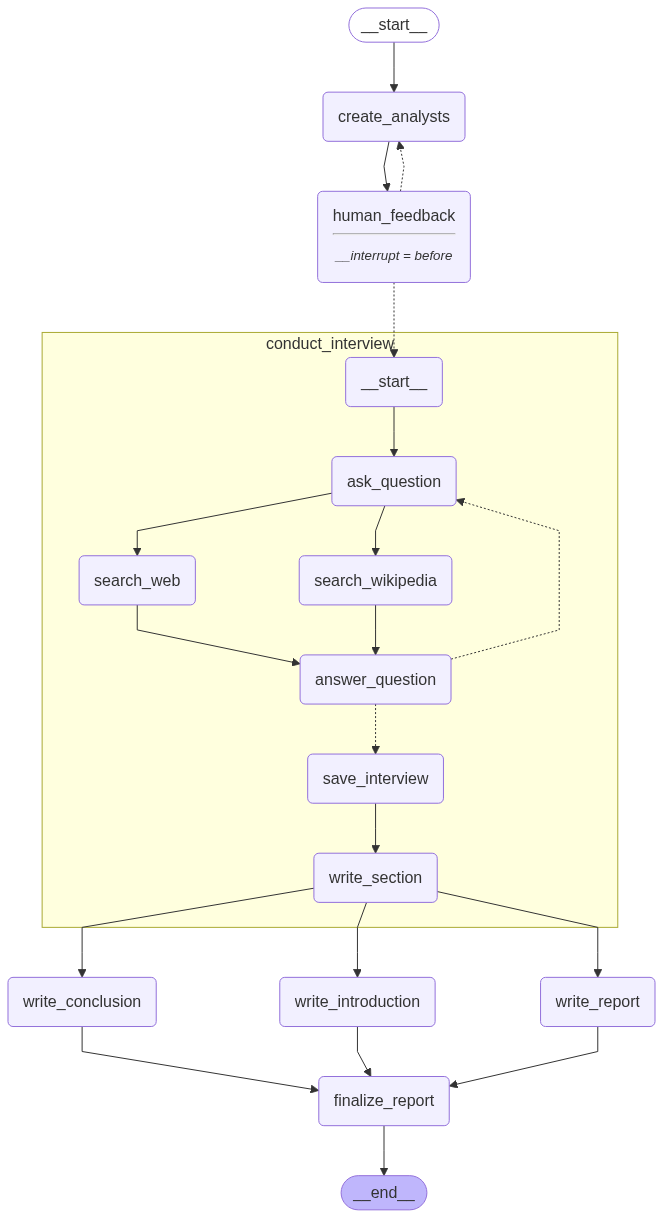

In [31]:
report_builder = StateGraph(ResearchGraphState)

# Add nodes
report_builder.add_node("create_analysts", create_analysts)
report_builder.add_node("human_feedback", human_feedback)
report_builder.add_node("conduct_interview", interview_builder.compile())
report_builder.add_node("write_introduction", write_introductions)
report_builder.add_node("write_conclusion", write_conclusion)
report_builder.add_node("write_report", write_report)
report_builder.add_node("finalize_report", finalize_report)

# Add edges
report_builder.add_edge(START, "create_analysts")
report_builder.add_edge("create_analysts", "human_feedback")
report_builder.add_conditional_edges(
    "human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"]
)
report_builder.add_edge("conduct_interview", "write_report")
report_builder.add_edge("conduct_interview", "write_introduction")
report_builder.add_edge("conduct_interview", "write_conclusion")
report_builder.add_edge("write_introduction", "finalize_report")
report_builder.add_edge("write_conclusion", "finalize_report")
report_builder.add_edge(
    ["write_introduction", "write_conclusion", "write_report"], "finalize_report"
)
report_builder.add_edge("finalize_report", END)

# Compile the graph
memory = MemorySaver()
langfuse_handler = CallbackHandler()
config = RunnableConfig(
    run_name="Create Research Report",
    callbacks=[langfuse_handler],
)
report_graph: CompiledStateGraph = report_builder.compile(
    interrupt_before=["human_feedback"], checkpointer=memory
).with_config(config)

# Visualize the graph
display(Image(report_graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# Inputs
max_analysts: int = 3
topic: str = "The benefits of Christianity"
messages = [
    HumanMessage(content=f"So you said you were writing an article on {topic}?")
]
thread: dict[str, Any] = {"configurable": {"thread_id": "1"}, "recursion_limit": 100}
input_values: dict[str, Any] = {"topic": topic, "max_analysts": max_analysts}

async for event in report_graph.astream(input_values, thread, stream_mode="values"):
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

In [ ]:
# The next step is t update the state as if we're the human_feedback node
report_graph.update_state(
    thread,
    {
        "human_analyst_feedback": "Add a priest with an apostolic and traditional perspective"
    },
    as_node="human_feedback",
)

In [ ]:
# Continue the graph execution
input_values: dict[str, Any] | None = None

# Run the graph
async for event in report_graph.astream(input_values, thread, stream_mode="values"):
    analysts = event.get("analysts", "")

    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Role: {analyst.role}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

In [ ]:
# Confirm that we're satisfied
further_feedback: str | None = None
report_graph.update_state(
    thread, {"human_analyst_feedback": further_feedback}, as_node="human_feedback"
)

In [ ]:
# Continue the graph execution to the end
input_values: dict[str, Any] | None = None  # Continue the graph execution

# Run the graph
async for event in report_graph.astream(
    input_values,
    thread,
    stream_mode="updates",  # NEW - Use "updates" instead of "values"
):
    print("--Node--")
    node_name: str = next(iter(event.keys()))
    print(node_name)

In [ ]:
final_state = report_graph.get_state(thread)
report = final_state.values["final_report"]

Markdown(report)